In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from scipy.special import softmax
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('reddit_data/sample_data.xlsx')

### Test Base Model

In [ ]:
# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Function to get sentiment scores and classification
def analyze_sentiment(text):
    # Encode text
    encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    
    # Get model output
    with torch.no_grad():
        output = model(**encoded_text)
    
    # Get scores and normalize
    scores = output.logits[0].numpy()
    scores = softmax(scores)
        
    # Get stance code (1=positive, 2=neutral, 3=negative)
    stance_code = np.argmax(scores)
    
    return stance_code, scores

# Apply the function to the dataframe
stance_results = []
scores_results = []

# Process in batches to show progress
total_rows = len(df)
for i, row in enumerate(df['Text']):
    stance, scores = analyze_sentiment(row)
    stance_results.append(stance)
    scores_results.append(scores)
    
    # Print progress every 100 rows
    if (i + 1) % 100 == 0:
        print(f"Processed {i+1}/{total_rows} posts")

# Add results to dataframe
df['Predicted_Stance_Code'] = stance_results
df['Negative_Score'] = [scores[0] for scores in scores_results]
df['Neutral_Score'] = [scores[1] for scores in scores_results]
df['Positive_Score'] = [scores[2] for scores in scores_results]

# Compare predictions with original Stance Code
if 'Stance Code' in df.columns:
    accuracy = (df['Predicted_Stance_Code'] == df['Stance Code']).mean()
    print(f"Prediction accuracy: {accuracy:.4f}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processed 100/900 posts
Processed 200/900 posts
Processed 300/900 posts
Processed 400/900 posts
Processed 500/900 posts
Processed 600/900 posts
Processed 700/900 posts
Processed 800/900 posts
Processed 900/900 posts
Prediction accuracy: 0.7978


### Fine Tuning

In [3]:
#Set up dataset class
class RedditSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare data for fine-tuning
def prepare_data(df):
    
    # Split into train and validation sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Stance Code'])
    
    return train_df, val_df

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in data_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

# Updated Main fine-tuning function
def fine_tune_sentiment_model(df, epochs=3, batch_size=8, learning_rate=2e-5):
    train_df, val_df = prepare_data(df)
    
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
    
    # Create datasets
    train_dataset = RedditSentimentDataset(
        texts=train_df['Text'].values,
        labels=train_df['Stance Code'].values,
        tokenizer=tokenizer
    )
    
    val_dataset = RedditSentimentDataset(
        texts=val_df['Text'].values,
        labels=val_df['Stance Code'].values,
        tokenizer=tokenizer
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Set up device
    device = torch.device('cpu')
    model.to(device)
    
    # Set up optimizer and scheduler
    optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_accuracy = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f"Training loss: {train_loss:.4f}")
        
        # Evaluate
        val_accuracy, val_report = evaluate(model, val_loader, device)
        print(f"Validation accuracy: {val_accuracy:.4f}")
        print(val_report)
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            model.save_pretrained("./reddit_sentiment_model")
            tokenizer.save_pretrained("./reddit_sentiment_model")
            print("Model saved!")
    
    return model, tokenizer

In [15]:
fine_tuned_model, fine_tuned_tokenizer = fine_tune_sentiment_model(df, epochs=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/3
Training loss: 0.6215
Validation accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        88
           1       0.82      0.85      0.83        65
           2       0.94      0.59      0.73        27

    accuracy                           0.83       180
   macro avg       0.86      0.78      0.81       180
weighted avg       0.84      0.83      0.83       180

Model saved!
Epoch 2/3
Training loss: 0.3097
Validation accuracy: 0.8667
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        88
           1       0.86      0.85      0.85        65
           2       0.84      0.78      0.81        27

    accuracy                           0.87       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.87      0.87      0.87       180

Model saved!
Epoch 3/3
Training loss: 0.2069
Validation accuracy: 0.8722
              precision    recal

### Evaluation

=== Final Evaluation ===
Final validation accuracy: 0.8722
              precision    recall  f1-score   support

           0       0.90      0.91      0.90        88
           1       0.83      0.85      0.84        65
           2       0.88      0.81      0.85        27

    accuracy                           0.87       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.87      0.87       180



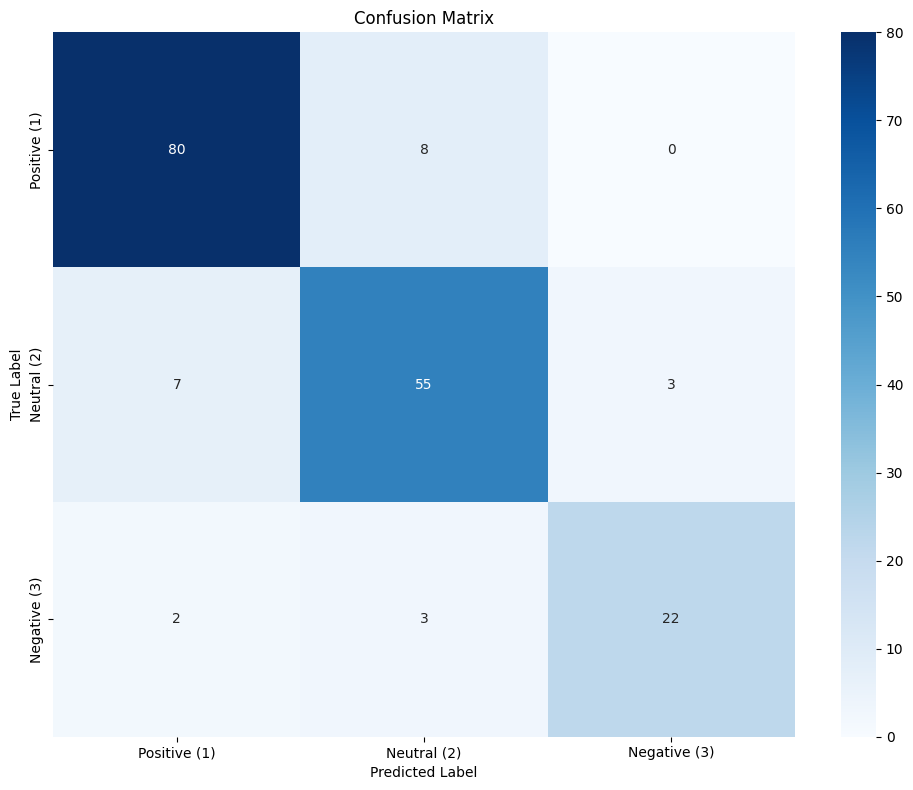

In [ ]:
# Load the fine-tuned model
model_path = "./reddit_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create validation dataset and loader
train_df, val_df = prepare_data(df)

val_dataset = RedditSentimentDataset(
    texts=val_df['Text'].values,
    labels=val_df['Stance Code'].values,
    tokenizer=tokenizer
)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cpu')
model.to(device)

# Run evaluation
model.eval()
predictions = []
actual_labels = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        probs = torch.softmax(outputs.logits, dim=1)
        all_probs.extend(probs.cpu().numpy())
        _, preds = torch.max(outputs.logits, dim=1)
        
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predictions)
report = classification_report(actual_labels, predictions)

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predictions)

print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (0)', 'Neutral (1)', 'Positive (2)'],
            yticklabels=['Negative (0)', 'Neutral (1)', 'Positive (2)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Classification

In [ ]:
# Load the fine-tuned model and tokenizer
model_path = "./reddit_sentiment_model"  # Path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set to evaluation mode

# Load your data
input_file = "reddit_data/combined_data_without_sample.xlsx"
print("Loading data from:", input_file)
df = pd.read_excel(input_file)
print(f"Data loaded. Shape: {df.shape}")

# Apply the function to the dataframe
stance_results = []
scores_results = []

# Process in batches to show progress
total_rows = len(df)
print(f"Starting to process {total_rows} posts...")

for i, row in enumerate(df['Text']):
    stance, scores = analyze_sentiment(row)
    stance_results.append(stance)
    scores_results.append(scores)
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i+1}/{total_rows} posts ({((i+1)/total_rows*100):.1f}%)")

print("Processing complete!")

# Add results to dataframe
df['Stance Code'] = stance_results
df['Negative_Score'] = [scores[0] for scores in scores_results]
df['Neutral_Score'] = [scores[1] for scores in scores_results]
df['Positive_Score'] = [scores[2] for scores in scores_results]

stance_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['Sentiment'] = df['Stance Code'].map(stance_names)

# Display results and save
print("\nFirst few rows with predictions:")
print(df[['ID', 'Text', 'Stance Code', 'Sentiment', 'Positive_Score', 'Neutral_Score', 'Negative_Score']].head())

print("\nSentiment distribution:")
print(df['Sentiment'].value_counts())
print("\nPercentages:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

Loading data from: reddit_data/combined_data_without_sample.xlsx
Data loaded. Shape: (71459, 5)
Starting to process 71459 posts...
Processed 100/71459 posts (0.1%)
Processed 200/71459 posts (0.3%)
Processed 300/71459 posts (0.4%)
Processed 400/71459 posts (0.6%)
Processed 500/71459 posts (0.7%)
Processed 600/71459 posts (0.8%)
Processed 700/71459 posts (1.0%)
Processed 800/71459 posts (1.1%)
Processed 900/71459 posts (1.3%)
Processed 1000/71459 posts (1.4%)
Processed 1100/71459 posts (1.5%)
Processed 1200/71459 posts (1.7%)
Processed 1300/71459 posts (1.8%)
Processed 1400/71459 posts (2.0%)
Processed 1500/71459 posts (2.1%)
Processed 1600/71459 posts (2.2%)
Processed 1700/71459 posts (2.4%)
Processed 1800/71459 posts (2.5%)
Processed 1900/71459 posts (2.7%)
Processed 2000/71459 posts (2.8%)
Processed 2100/71459 posts (2.9%)
Processed 2200/71459 posts (3.1%)
Processed 2300/71459 posts (3.2%)
Processed 2400/71459 posts (3.4%)
Processed 2500/71459 posts (3.5%)
Processed 2600/71459 posts (

In [20]:
df.to_excel('reddit_data/combined_data_with_classification.xlsx', index=False)